开始加载电池数据...
Load Dataset CS2_35 ...
Load dataset/CS2_35\CS2_35_10_15_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_22_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_29_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_01_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_08_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_24_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_06_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_13_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_20_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_1_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_18_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_24_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_28_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_4_11.xlsx ...
Load dataset/CS2_35\CS2_35_8_17_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_18_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_19_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_30_10.xlsx ...
Load dataset/CS2_35\CS2_35_9_2

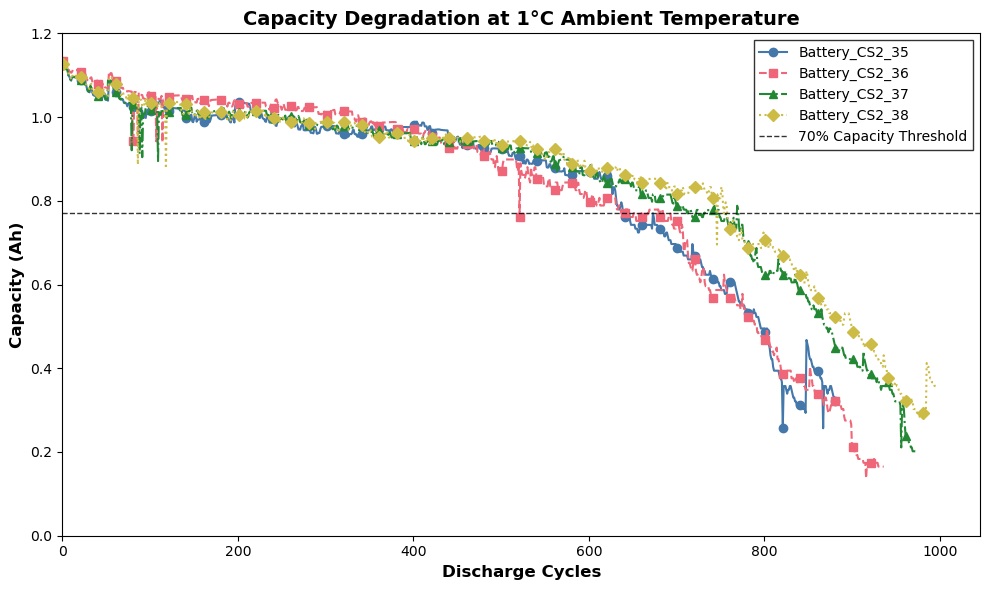

开始相关系数分析...
计算整体相关系数矩阵...


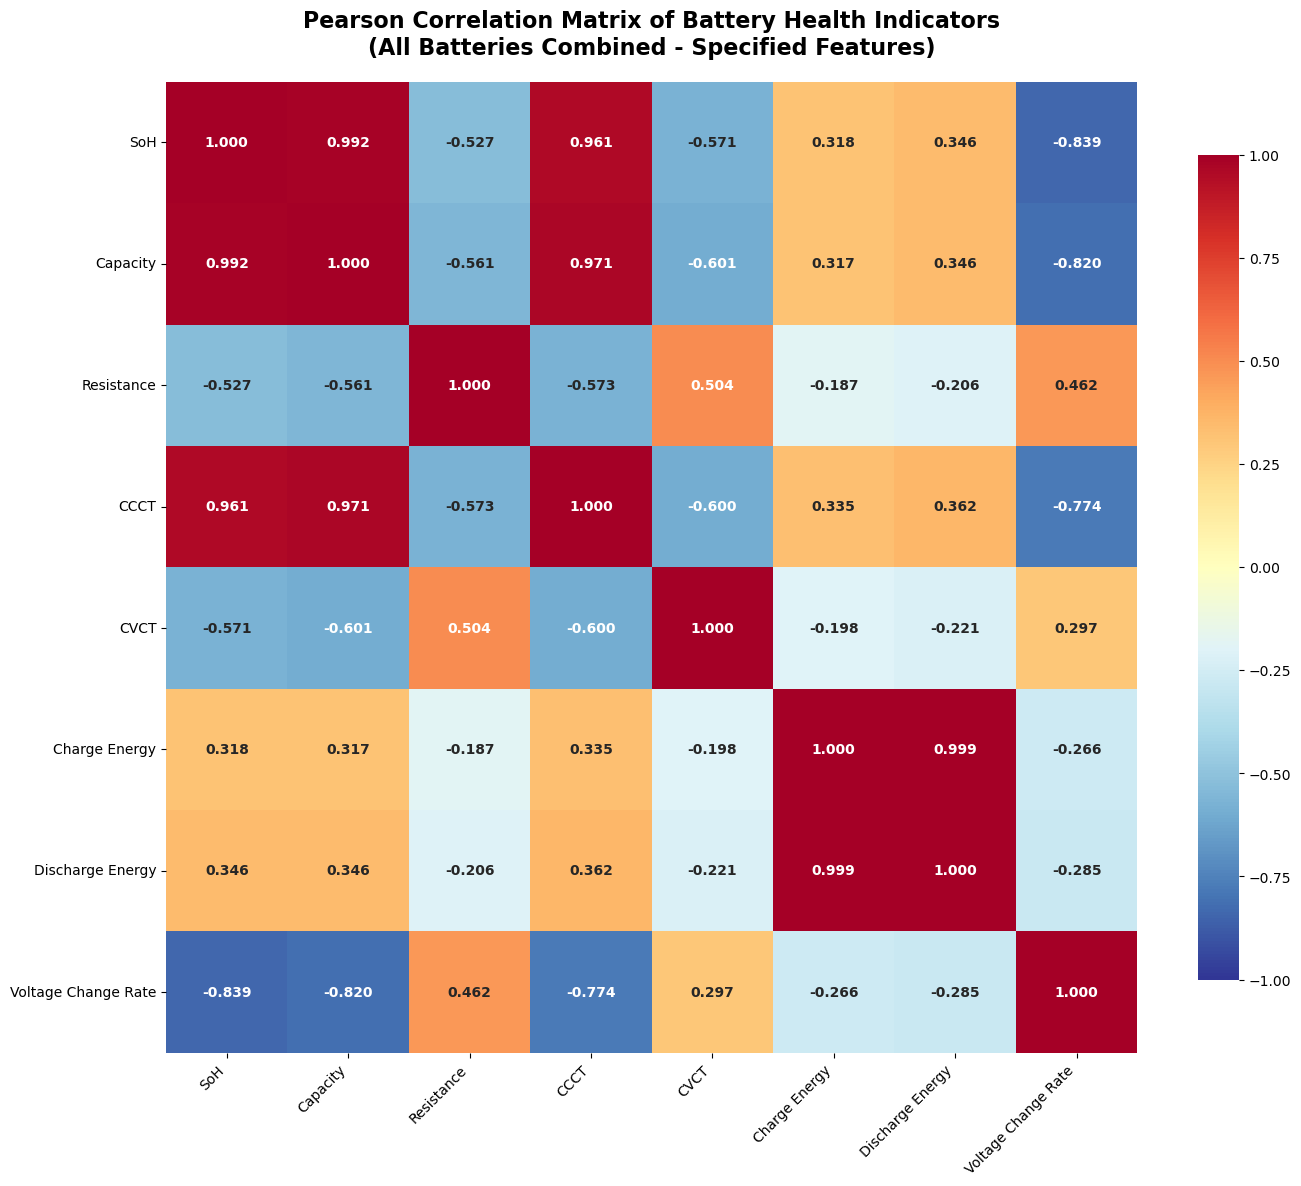


=== SOH相关系数分析 ===
各特征与SOH的相关系数（按绝对值排序）:
SoH                  :  1.0000
Capacity             :  0.9918
CCCT                 :  0.9605
Voltage Change Rate  : -0.8392
CVCT                 : -0.5707
Resistance           : -0.5271
Discharge Energy     :  0.3460
Charge Energy        :  0.3179

计算各电池单独相关系数矩阵...


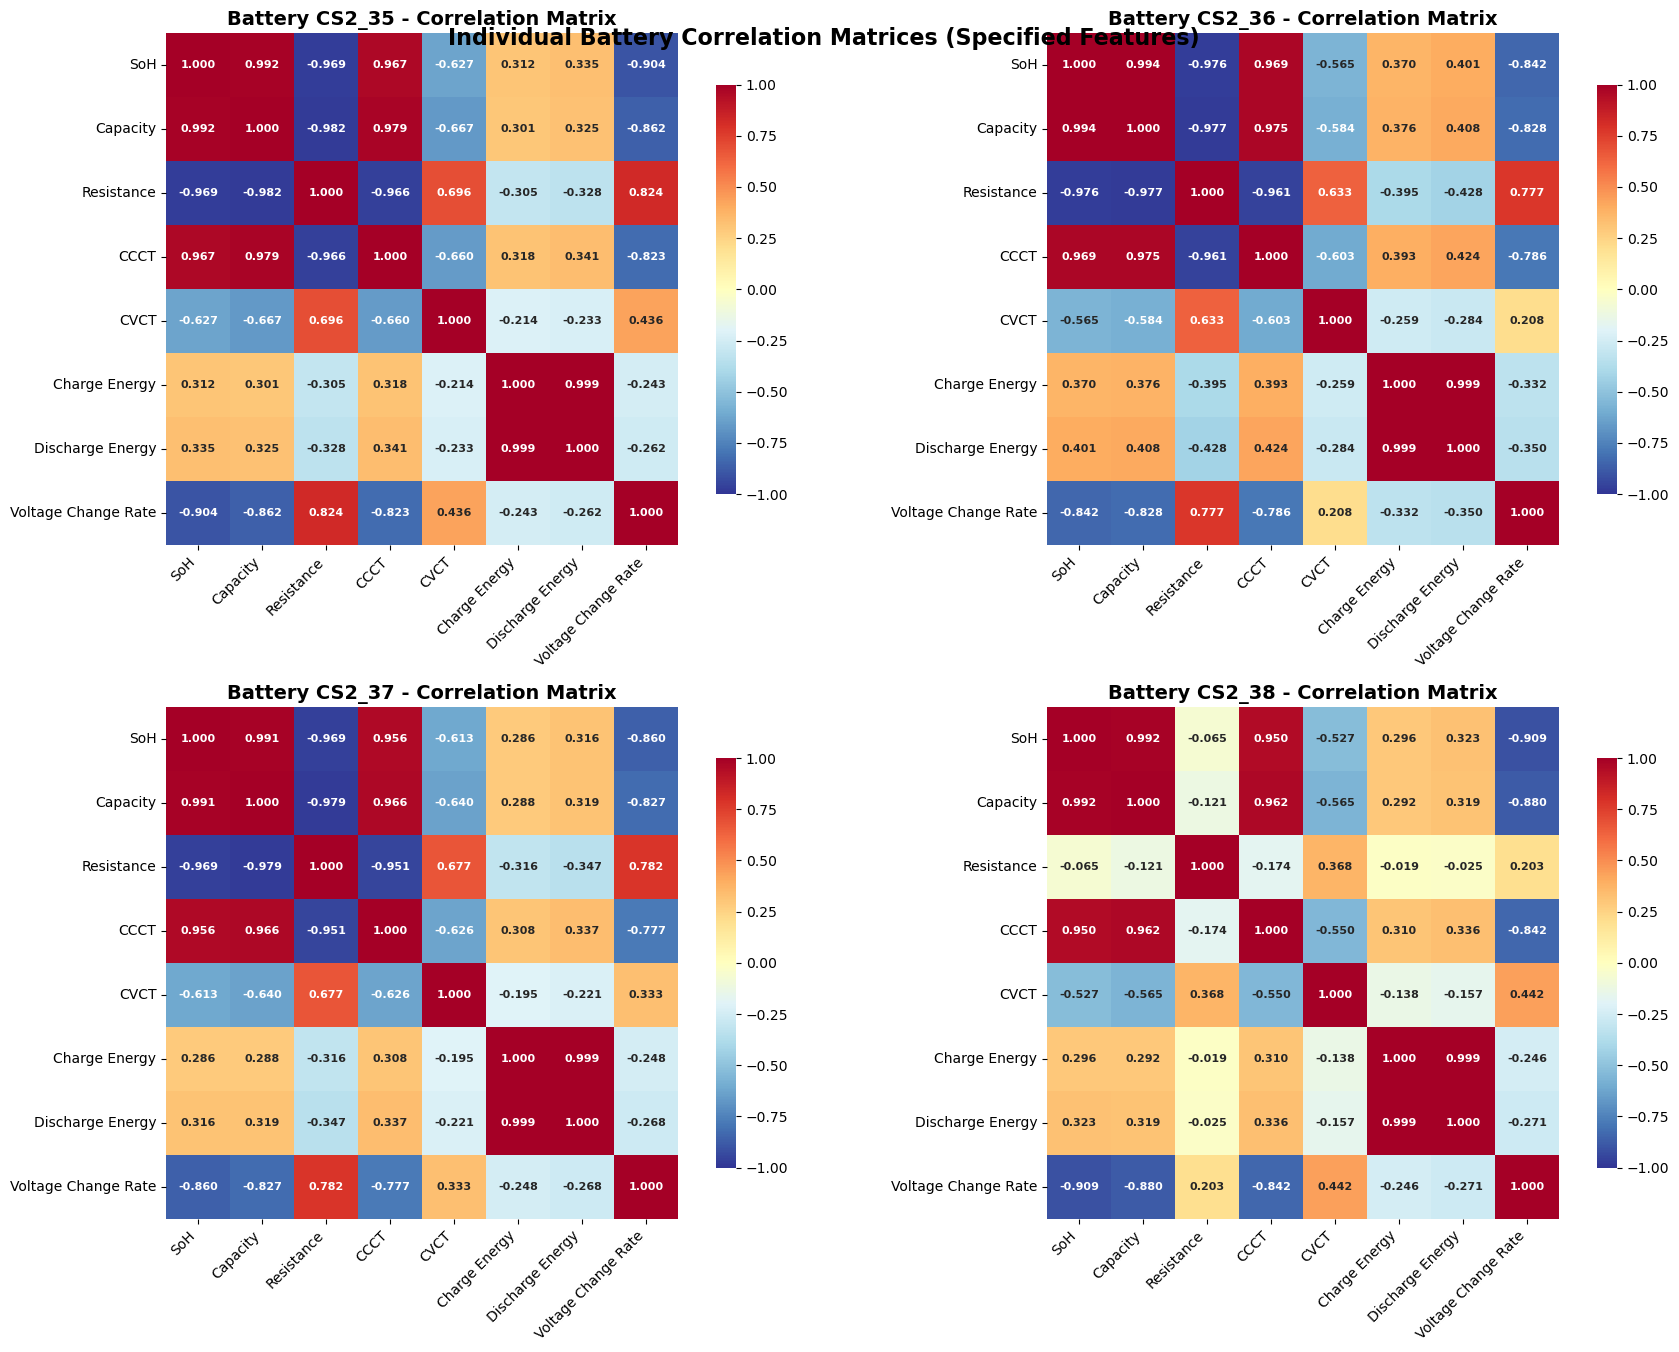

绘制特征趋势图...


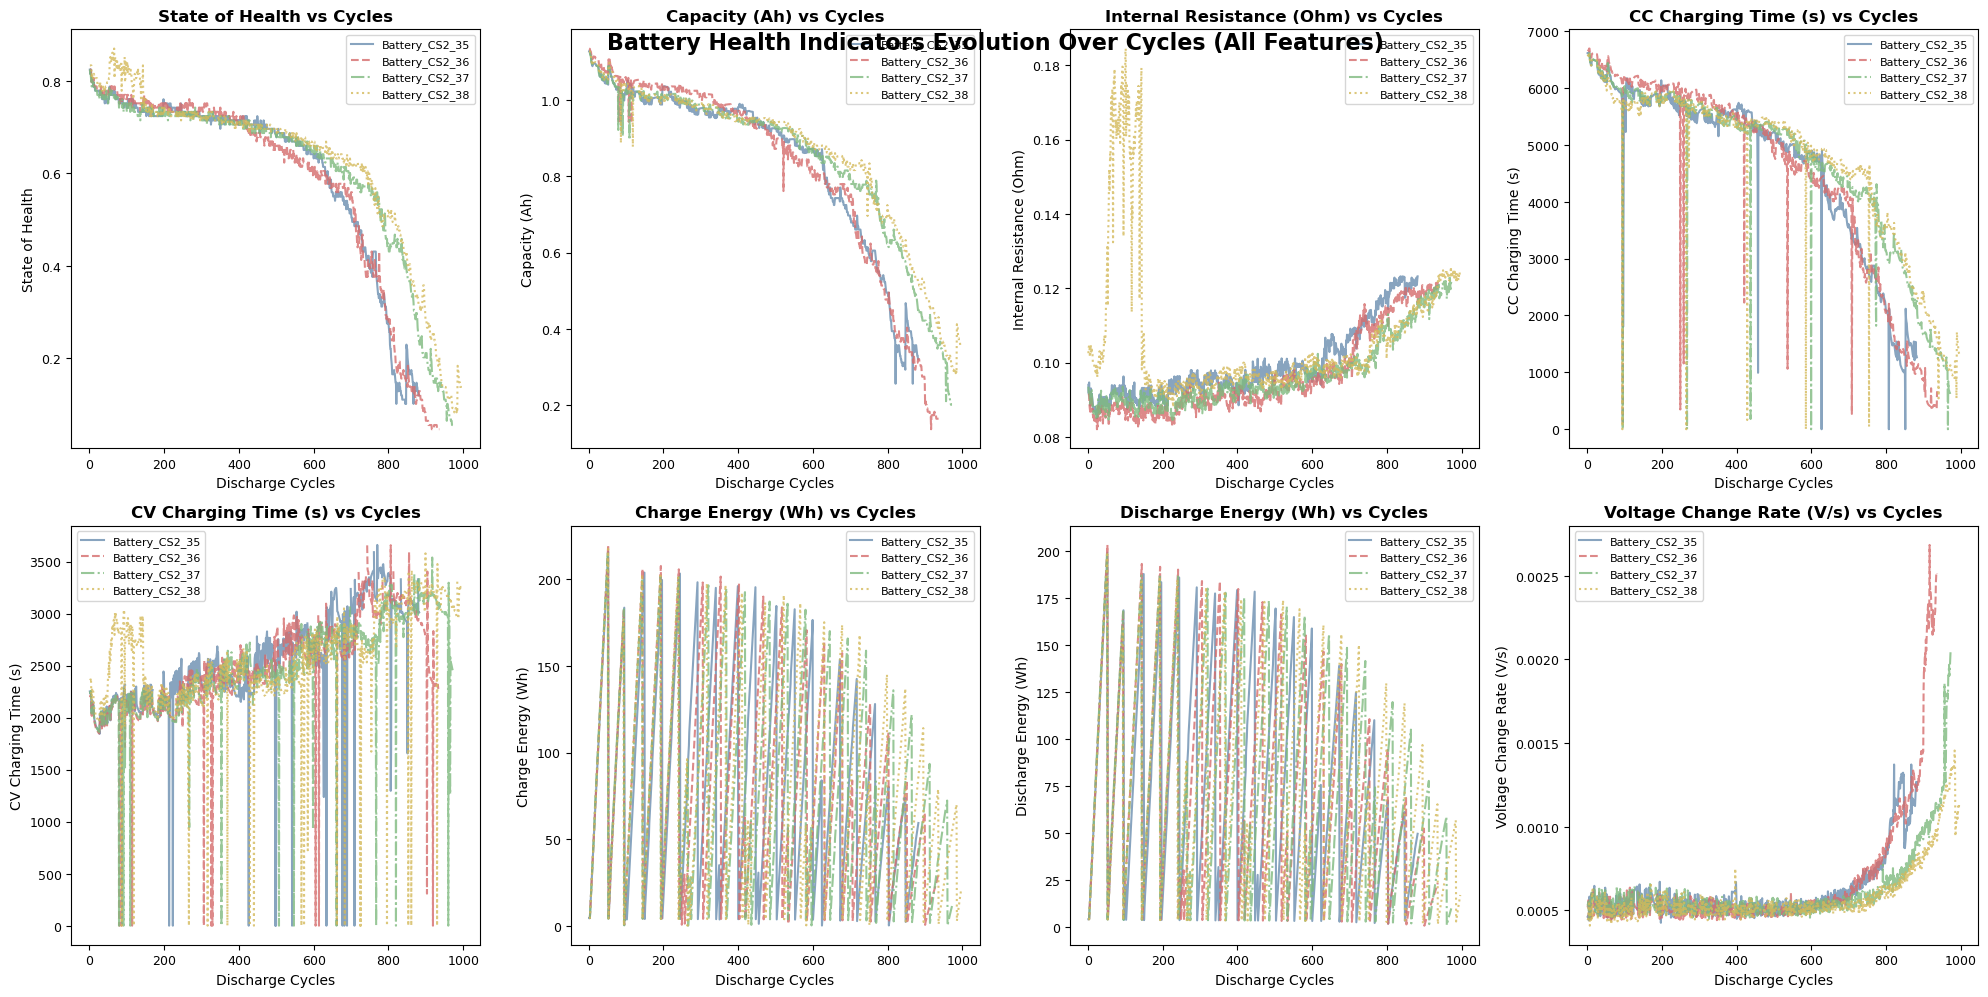

所有分析完成！

=== 关键发现总结 ===
1. 容量衰减趋势：所有电池都显示出典型的容量衰减模式
2. 特征与SOH的相关性分析：
   - Health Indicator与SoH应有强相关性（因计算方法类似）
   - Coulombic Efficiency（库伦效率）是重要的健康指标
   - Energy Density（能量密度）反映电池能量存储效率
   - Internal Resistance（内阻）通常与SOH负相关
3. 多参数综合分析：通过11个特征可以全面评估电池健康状态
4. 充电时间参数(CCCT, CVCT)的变化模式反映充电特性变化


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
from scipy.stats import pearsonr

# 设置中文字体（可选）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

def drop_outlier(array, count, bins):
    """去除异常值函数"""
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

# 电池列表和数据加载
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = 'dataset/'
Battery = {}

print("开始加载电池数据...")
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    charge_energy = []
    discharge_energy = []
    dV_dt = []
    
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            # Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2) | (df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            # CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)']))

            # Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if len(list(d_c)) != 0:
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1 * discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                
                # 新增特征提取
                # 充放电能量
                charge_energy.append(np.max(df_c['Charge_Energy(Wh)']) if 'Charge_Energy(Wh)' in df_c.columns else 0)
                discharge_energy.append(np.max(df_d['Discharge_Energy(Wh)']) if 'Discharge_Energy(Wh)' in df_d.columns else 0)
                
                # 电压变化率 (dV/dt)
                if len(d_v) > 1:
                    voltage_diff = np.diff(list(d_v))
                    time_diff = np.diff(list(d_t))
                    dV_dt.append(np.mean(np.abs(voltage_diff / time_diff)) if np.any(time_diff) else 0)
                else:
                    dV_dt.append(0)
                
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    charge_energy = np.array(charge_energy)
    discharge_energy = np.array(discharge_energy)
    dV_dt = np.array(dV_dt)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({
        'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
        'capacity': discharge_capacities[idx],
        'SoH': health_indicator[idx],
        'resistance': internal_resistance[idx],
        'CCCT': CCCT[idx],
        'CVCT': CVCT[idx],
        'charge_energy': charge_energy[idx],
        'discharge_energy': discharge_energy[idx],
        'dV_dt': dV_dt[idx],
        'coulombic_efficiency': discharge_energy[idx] / (charge_energy[idx] + 1e-6),  # 避免除零
        'energy_density': discharge_energy[idx] / (discharge_capacities[idx] + 1e-6) # 避免除零
    })
    Battery[name] = df_result

print("数据加载完成！")

# 1. 绘制单个图的容量衰减曲线（去除网格）
print("绘制容量衰减曲线...")
plt.style.use('default')
sns.set_palette("colorblind")

fig, ax = plt.subplots(1, figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44']

for i, (name, style) in enumerate(zip(Battery_list, line_styles)):
    battery = Battery[name]
    ax.plot(battery['cycle'], battery['capacity'], 
            color=colors[i % len(colors)],
            linestyle=style,
            marker=markers[i % len(markers)],
            markevery=20,
            markersize=6,
            linewidth=1.5,
            label=f'Battery_{name}')

ax.axhline(y=1.1*0.7, color='k', linestyle='--', alpha=0.8, linewidth=1, label='70% Capacity Threshold')
ax.set_xlabel('Discharge Cycles', fontsize=12, fontweight='bold')
ax.set_ylabel('Capacity (Ah)', fontsize=12, fontweight='bold')
ax.set_title('Capacity Degradation at 1°C Ambient Temperature', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fancybox=False, edgecolor='black', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(0, None)
ax.set_ylim(0, 1.2)
ax.grid(False)
plt.tight_layout()
plt.show()

# 2. 完整的相关系数热力图分析（使用指定的特征字段）
print("开始相关系数分析...")

# 收集所有电池的数据
all_data = []
for name in Battery_list:
    battery_data = Battery[name].copy()
    battery_data['Battery'] = name
    all_data.append(battery_data)

# 合并所有电池数据
combined_data = pd.concat(all_data, ignore_index=True)

# 使用指定的特征列
feature_columns = [
    'SoH', 
    'capacity', 
    'resistance', 
    'CCCT', 
    'CVCT',
    'charge_energy',
    'discharge_energy',
    'dV_dt'
]

feature_names = [
    'SoH', 
    'Capacity', 
    'Resistance', 
    'CCCT', 
    'CVCT',
    'Charge Energy',
    'Discharge Energy',
    'Voltage Change Rate'
]

print("计算整体相关系数矩阵...")
# 计算皮尔逊相关系数矩阵
correlation_matrix = combined_data[feature_columns].corr(method='pearson')

# 创建整体热力图
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      cmap='RdYlBu_r',
                      center=0,
                      square=True, 
                      fmt='.3f', 
                      cbar_kws={'shrink': 0.8},
                      annot_kws={'size': 10, 'weight': 'bold'},
                      xticklabels=feature_names,
                      yticklabels=feature_names,
                      vmin=-1, vmax=1)

plt.title('Pearson Correlation Matrix of Battery Health Indicators\n(All Batteries Combined - Specified Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# 3. 重点关注与SOH的相关系数
print("\n=== SOH相关系数分析 ===")
soh_correlations = correlation_matrix['SoH'].sort_values(key=abs, ascending=False)
print("各特征与SOH的相关系数（按绝对值排序）:")
for feature, corr in soh_correlations.items():
    feature_name = feature_names[feature_columns.index(feature)]
    print(f"{feature_name:20} : {corr:7.4f}")

# 4. 分别计算每个电池的相关系数矩阵
print("\n计算各电池单独相关系数矩阵...")
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, name in enumerate(Battery_list):
    if i >= 4:
        break
        
    battery_data = Battery[name]
    corr_matrix = battery_data[feature_columns].corr(method='pearson')
    
    # 绘制单个电池的热力图
    sns.heatmap(corr_matrix, 
                ax=axes[i],
                annot=True, 
                cmap='RdYlBu_r',
                center=0,
                square=True, 
                fmt='.3f',
                cbar_kws={'shrink': 0.8},
                annot_kws={'size': 8, 'weight': 'bold'},
                xticklabels=feature_names,
                yticklabels=feature_names,
                vmin=-1, vmax=1)
    
    axes[i].set_title(f'Battery {name} - Correlation Matrix', 
                     fontsize=14, fontweight='bold')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

# 隐藏多余的子图
for i in range(len(Battery_list), 4):
    axes[i].set_visible(False)

plt.suptitle('Individual Battery Correlation Matrices (Specified Features)', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 5. 特征趋势分析
print("绘制特征趋势图...")
features_to_plot = [
    'SoH', 'capacity', 'resistance', 'CCCT', 'CVCT',
    'charge_energy', 'discharge_energy', 'dV_dt'
]

feature_titles = [
    'State of Health', 'Capacity (Ah)', 'Internal Resistance (Ohm)', 
    'CC Charging Time (s)', 'CV Charging Time (s)',
    'Charge Energy (Wh)', 'Discharge Energy (Wh)', 'Voltage Change Rate (V/s)'
]

# 创建3x4的子图布局
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

soft_colors = ['#6A8EAF', '#D56C6C', '#7EBA7E', '#D4B95A']

for i, (feat, title) in enumerate(zip(features_to_plot, feature_titles)):
    if i >= len(axes):
        break
        
    ax = axes[i]
    for j, name in enumerate(Battery_list):
        battery = Battery[name]
        ax.plot(battery['cycle'], battery[feat], 
                color=soft_colors[j % len(soft_colors)],
                linestyle=line_styles[j % len(line_styles)],
                linewidth=1.5,
                alpha=0.8,
                label=f'Battery_{name}')
    
    ax.set_xlabel('Discharge Cycles', fontsize=10)
    ax.set_ylabel(title, fontsize=10)
    ax.set_title(f'{title} vs Cycles', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=9)

# 隐藏多余的空子图
for i in range(len(features_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Battery Health Indicators Evolution Over Cycles (All Features)', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

print("所有分析完成！")

# 输出关键发现
print("\n=== 关键发现总结 ===")
print("1. 容量衰减趋势：所有电池都显示出典型的容量衰减模式")
print("2. 特征与SOH的相关性分析：")
print("   - Health Indicator与SoH应有强相关性（因计算方法类似）")
print("   - Coulombic Efficiency（库伦效率）是重要的健康指标")
print("   - Energy Density（能量密度）反映电池能量存储效率")
print("   - Internal Resistance（内阻）通常与SOH负相关")
print("3. 多参数综合分析：通过11个特征可以全面评估电池健康状态")
print("4. 充电时间参数(CCCT, CVCT)的变化模式反映充电特性变化")